In [9]:
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from os.path import expanduser
import detr_tf
from detr_tf.data import load_coco_dataset
from detr_tf.networks.detr import get_detr_model

from detr_tf.training_config import TrainingConfig, DataConfig
from detr_tf.inference import numpy_bbox_to_image
from detr_tf.optimizers import setup_optimizers
from detr_tf import training
from detr_tf.inference import get_model_inference, numpy_bbox_to_image

In [10]:

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) == 1:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Create a config

In [11]:
class TrainConfig(TrainingConfig):
    def __init__(self):
        super().__init__()
        self.data_dir = "C:/Users/Admin/Development/Jupyter Note Books/DETR/new/Working"
        self.data = DataConfig(data_dir=self.data_dir, img_dir="train", ann_dir="Annotations")
        self.image_size = (500, 500)
        self.normalized_method = 'tf_resnet'

train_config = TrainConfig()
train_iterator, class_names = load_coco_dataset(train_config, train_config.batch_size, augmentation=True)

class ValidConfig(TrainingConfig):
    def __init__(self):
        super().__init__()
        self.data_dir = "C:/Users/Admin/Development/Jupyter Note Books/DETR/SixRay_10_split/val"
        self.data = DataConfig(data_dir=self.data_dir, img_dir="Proposals", ann_dir="Annotations")
        self.image_size = (500, 500)
        self.normalized_method = 'tf_resnet'

valid_config = ValidConfig()
valid_iterator, _ = load_coco_dataset(valid_config, valid_config.batch_size, augmentation=None)

images.shape (1, 480, 720, 3)
target_bbox.shape (1, 100, 4)
target_class.shape (1, 100, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


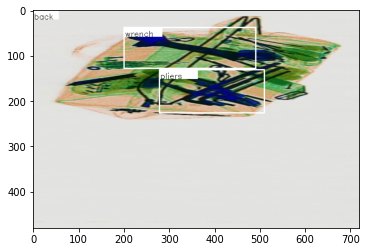

In [12]:
for images, target_bbox, target_class in train_iterator:
    print("images.shape", images.shape)
    print("target_bbox.shape", target_bbox.shape)
    print("target_class.shape", target_class.shape)

    # Plot image
    image = numpy_bbox_to_image(
        np.array(images[0]),
        np.array(target_bbox[0]),
        labels=np.array(target_class[0]),
        scores=None,
        class_name=class_names,
        config=train_config
    )
    plt.imshow(image)
    break

In [13]:
class_names

['back', 'knife', 'gun', 'wrench', 'pliers', 'scissors']

In [14]:
detr = get_detr_model(train_config, include_top=False, nb_class=14, weights="detr", tf_backbone=True)
detr.summary()

Load weights from weights/detr\detr.ckpt
Loading CNN_Weights tf_resnet
Model: "detr_finetuning"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 detr (Functional)              (6, None, 100, 256)  41475712    ['input_6[0][0]']                
                                                                                                  
 pos_layer (Sequential)         (6, None, 100, 4)    132612      ['detr[0][0]']                   
                                                                                                  
 cls_layer (D

In [15]:
train_config.train_backbone = tf.Variable(False)
train_config.train_transformers = tf.Variable(False)
train_config.train_nlayers = tf.Variable(True)
train_config.nlayers_lr = tf.Variable(1e-3)

optimzers = setup_optimizers(detr, train_config)

In [16]:
for epoch in range(100):
    training.fit(detr, train_iterator, optimzers, train_config, epoch_nb=epoch, class_names=class_names)

Epoch: [0], 	 Step: [0], 	 ce: [2.03] 	 giou : [0.61] 	 l1 : [0.38] 	 time : [0.00]
Epoch: [0], 	 Step: [100], 	 ce: [0.44] 	 giou : [0.89] 	 l1 : [0.51] 	 time : [59.86]


In [ ]:
for valid_images, target_bbox, target_class in valid_iterator:    
    m_outputs = detr(valid_images, training=False)
    predicted_bbox, predicted_labels, predicted_scores = get_model_inference(m_outputs, valid_config.background_class, bbox_format="xy_center")
    print(predicted_bbox)
    print(predicted_labels)
    print(predicted_scores)

    result = numpy_bbox_to_image(
        np.array(valid_images[0]),
        np.array(predicted_bbox),
        np.array(predicted_labels),
        scores=np.array(predicted_scores),
        class_name=class_names, 
        config=valid_config
    )
    plt.imshow(result)
    plt.show()
    break

In [ ]:
train_config.train_transformers.assign(True)
train_config.transformers_lr.assign(1e-4)
train_config.nlayers_lr.assign(1e-3)

In [ ]:
for epoch in range(100):
    training.fit(detr, train_iterator, optimzers, train_config, epoch_nb=epoch, class_names=class_names)

In [ ]:
for valid_images, target_bbox, target_class in valid_iterator:    
    m_outputs = detr(valid_images, training=False)
    predicted_bbox, predicted_labels, predicted_scores = get_model_inference(m_outputs, valid_config.background_class, bbox_format="xy_center")
    print(predicted_bbox)
    print(predicted_labels)
    print(predicted_scores)

    result = numpy_bbox_to_image(
        np.array(valid_images[0]),
        np.array(predicted_bbox),
        np.array(predicted_labels),
        scores=np.array(predicted_scores),
        class_name=class_names, 
        config=valid_config
    )
    plt.imshow(result)
    plt.show()
    break

In [ ]:
detr.save_weights("./saved/DETR_100_100_weights.ckpt")

In [ ]:
from detr_tf.loss.compute_map import cal_map, calc_map, APDataObject
from detr_tf.bbox import xcycwh_to_xy_min_xy_max, xcycwh_to_yx_min_yx_max
def eval_model(model, config, class_names, valid_dt):
    """ Run evaluation
    """

    iou_thresholds = [x / 100. for x in range(50, 100, 5)]
    ap_data = {
        'box' : [[APDataObject() for _ in class_names] for _ in iou_thresholds],
        'mask': [[APDataObject() for _ in class_names] for _ in iou_thresholds]
    }
    it = 0

    for images, target_bbox, target_class in valid_dt:
        # Forward pass
        m_outputs = model(images)
        # Run predictions
        p_bbox, p_labels, p_scores = get_model_inference(m_outputs, config.background_class, bbox_format="yxyx")
        # Remove padding
        t_bbox, t_class = target_bbox[0], target_class[0]
        size = tf.cast(t_bbox[0][0], tf.int32)
        t_bbox = tf.slice(t_bbox, [1, 0], [size, 4])
        t_bbox = xcycwh_to_yx_min_yx_max(t_bbox)
        t_class = tf.slice(t_class, [1, 0], [size, -1])
        t_class = tf.squeeze(t_class, axis=-1)
        # Compute map
        cal_map(p_bbox, p_labels, p_scores,  np.zeros((138, 138, len(p_bbox))), np.array(t_bbox), np.array(t_class), np.zeros((138, 138, len(t_bbox))), ap_data, iou_thresholds)
        print(f"Computing map.....{it}", end="\r")
        it += 1
        #if it > 10:
        #    break

    # Compute the mAp over all thresholds
    calc_map(ap_data, iou_thresholds, class_names, print_result=True)

In [ ]:
eval_model(detr, valid_config, class_names, valid_iterator)

In [ ]:
class ValidConfig(TrainingConfig):
    def __init__(self):
        super().__init__()
        self.data_dir = "C:/Users/Admin/Development/Jupyter Note Books/DETR/SixRay_10_split/val"
        self.data = DataConfig(data_dir=self.data_dir, img_dir="Proposals", ann_dir="Annotations")
        self.image_size = (500, 500)
        self.normalized_method = 'tf_resnet'

valid_config = ValidConfig()
valid_iterator, class_names = load_coco_dataset(valid_config, valid_config.batch_size, augmentation=None)

In [ ]:
class_names

In [ ]:
for images, target_bbox, target_class in valid_iterator:
    print("images.shape", images.shape)
    print("target_bbox.shape", target_bbox.shape)
    print("target_class.shape", target_class.shape)

    # Plot image
    image = numpy_bbox_to_image(
        np.array(images[0]),
        np.array(target_bbox[0]),
        labels=np.array(target_class[0]),
        scores=None,
        class_name=class_names,
        config=valid_config
    )
    plt.imshow(image)
    break

In [ ]:
from detr_tf.networks.detr import get_detr_model
detr = get_detr_model(valid_config, include_top=False, nb_class=14, weights="detr", tf_backbone=True)
detr.summary()

In [ ]:
import argparse
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np

from detr_tf.inference import get_model_inference
from detr_tf.data.coco import load_coco_dataset
from detr_tf.loss.compute_map import cal_map, calc_map, APDataObject
from detr_tf.networks.detr import get_detr_model
from detr_tf.bbox import xcycwh_to_xy_min_xy_max, xcycwh_to_yx_min_yx_max
from detr_tf.inference import numpy_bbox_to_image
from detr_tf.training_config import TrainingConfig, training_config_parser

In [ ]:
def eval_model(model, config, class_names, valid_dt):
    """ Run evaluation
    """

    iou_thresholds = [x / 100. for x in range(50, 100, 5)]
    ap_data = {
        'box' : [[APDataObject() for _ in class_names] for _ in iou_thresholds],
        'mask': [[APDataObject() for _ in class_names] for _ in iou_thresholds]
    }
    it = 0

    for images, target_bbox, target_class in valid_dt:
        # Forward pass
        m_outputs = model(images)
        # Run predictions
        p_bbox, p_labels, p_scores = get_model_inference(m_outputs, config.background_class, bbox_format="yxyx")
        # Remove padding
        t_bbox, t_class = target_bbox[0], target_class[0]
        size = tf.cast(t_bbox[0][0], tf.int32)
        t_bbox = tf.slice(t_bbox, [1, 0], [size, 4])
        t_bbox = xcycwh_to_yx_min_yx_max(t_bbox)
        t_class = tf.slice(t_class, [1, 0], [size, -1])
        t_class = tf.squeeze(t_class, axis=-1)
        # Compute map
        cal_map(p_bbox, p_labels, p_scores,  np.zeros((138, 138, len(p_bbox))), np.array(t_bbox), np.array(t_class), np.zeros((138, 138, len(t_bbox))), ap_data, iou_thresholds)
        print(f"Computing map.....{it}", end="\r")
        it += 1
        #if it > 10:
        #    break

    # Compute the mAp over all thresholds
    calc_map(ap_data, iou_thresholds, class_names, print_result=True)

In [ ]:
detr.load_weights("C:/Users/Admin/Development/Jupyter Note Books/DETR/saved/10_epoch/DETR_weights.ckpt")
eval_model(detr, valid_config, class_names, valid_iterator)

In [ ]:
detr.load_weights("C:/Users/Admin/Development/Jupyter Note Books/DETR/saved/100_epoch/DETR_weights_100.ckpt")
eval_model(detr, valid_config, class_names, valid_iterator)

In [ ]:
detr.load_weights("C:/Users/Admin/Development/Jupyter Note Books/DETR/saved/200_epoch/DETR_weights_200.ckpt")
eval_model(detr, valid_config, class_names, valid_iterator)

In [ ]:
detr.load_weights("C:/Users/Admin/Development/Jupyter Note Books/DETR/saved/300_epoch/DETR_weights_300.ckpt")
eval_model(detr, valid_config, class_names, valid_iterator)

In [ ]:
detr.load_weights("C:/Users/Admin/Development/Jupyter Note Books/DETR/saved/400_epoch/DETR_weights_400.ckpt")
eval_model(detr, valid_config, class_names, valid_iterator)

In [ ]:
for valid_images, target_bbox, target_class in valid_iterator:    
    m_outputs = detr(valid_images, training=False)
    predicted_bbox, predicted_labels, predicted_scores = get_model_inference(m_outputs, valid_config.background_class, bbox_format="xy_center")

    result = numpy_bbox_to_image(
        np.array(valid_images[0]),
        np.array(predicted_bbox),
        np.array(predicted_labels),
        scores=np.array(predicted_scores),
        class_name=class_names, 
        config=valid_config
    )
    plt.imshow(result)
    plt.show()
    break